In [1]:
from azuremodels import llm, embeddings
import pandas as pd
from typing import List, Literal, TypedDict, Optional, Annotated
from pydantic import BaseModel, confloat
import operator
from langgraph.graph import StateGraph, START, END
from langchain_community.vectorstores import Chroma

# ========================================
# SCHEMAS
# ========================================

AssetClass = Literal[
    "BankFD",
    "DebtBond",
    "MF_Index",
    "MF_Flexi",
    "MF_SmallCap",
    "EQ_Banking",
    "EQ_Automobile",
    "EQ_IT",
    "EQ_FMCG",
    "EQ_MetalsMining",
    "EQ_OilGas",
    "EQ_Pharma",
    "EQ_Defense",
    "Gold",
    "Silver",
    "RealEstate",
    "Cryptocurrency"
]
ActionType = Literal["BUY", "SELL", "HOLD"]

class Transaction(BaseModel):
    action: ActionType
    asset_type: AssetClass
    percentage: confloat(ge=0, le=100)
    rationale: str

class RequiredRuleKeys(BaseModel):
    rule_keys: List[str]

class CustomPortfolioPlan(BaseModel):
    transactions: List[Transaction]
    overall_rationale: str

# ========================================
# STATE
# ========================================

class PortfolioAgentState(TypedDict, total=False):
    client_id: str
    client_metadata: Optional[dict]
    boundary_rules: Annotated[List[str], operator.add]
    general_strategies: Optional[List[dict]]
    portfolio_plan: Optional[CustomPortfolioPlan]
    marketCondtions: str
# ========================================
# NODES
# ========================================

def load_client_metadata_node(state):
    print("\n=== LOAD CLIENT METADATA ===")
    print(f"Client ID: {state['client_id']}")
    df = pd.read_csv("client.csv")
    match = df[df["client_id"] == state["client_id"]]
    if match.empty:
        raise ValueError(f"Client ID '{state['client_id']}' not found")
    metadata = match.iloc[0].to_dict()
    print(f"Loaded: {metadata}")
    return {"client_metadata": metadata}

def select_and_retrieve_boundary_rules_node(state):
    print("\n=== SELECT BOUNDARY RULES ===")
    print(f"Client metadata: {state['client_metadata']}")
    
    structured_llm = llm.with_structured_output(RequiredRuleKeys)
    
    result = structured_llm.invoke(f"""
Determine boundary rule keys for this client: {state["client_metadata"]}

Return JSON with rule_keys array. Examples:
- max_equity_for_low_risk
- crypto_cap
- gold_corridor
""")
    
    print(f"LLM result: {result}")
    print(f"Result type: {type(result)}")
    
    selected_keys = result.rule_keys if result else ["max_equity_for_low_risk", "crypto_cap"]
    print(f"Selected keys: {selected_keys}")
    
    vectorstore = Chroma(
        embedding_function=embeddings,
        collection_name="boundaryRules",
        persist_directory="boundaryRules"
    )
    
    collected_rules = []
    for key in selected_keys:
        docs = vectorstore.as_retriever().invoke(key)
        collected_rules.extend([d.page_content for d in docs])
    
    print(f"Collected {len(collected_rules)} rules")
    return {"boundary_rules": collected_rules}

def load_general_strategies_node(state):
    print("\n=== LOAD STRATEGIES ===")
    df = pd.read_csv("strategy_updated.csv")
    strategies = df.to_dict(orient="records")
    print(f"Loaded {len(strategies)} strategies")
    return {"general_strategies": strategies}

def generate_custom_portfolio_node(state):
    print("\n=== GENERATE PORTFOLIO ===")
    print(f"Client metadata exists: {state.get('client_metadata') is not None}")
    print(f"Boundary rules count: {len(state.get('boundary_rules', []))}")
    print(f"Strategies count: {len(state.get('general_strategies', []))}")
    
    structured_llm = llm.with_structured_output(CustomPortfolioPlan)
    
    prompt = fprompt = f"""
Create a valid CustomPortfolioPlan.

CLIENT CONTEXT:
{state["client_metadata"]}

MARKET CONDITION (explicitly use in rationale where relevant):
{state["marketCondtions"]}

BOUNDARY RULE TEXT (mandatory constraints extracted via RAG):
{state["boundary_rules"]}

BASELINE STRATEGY MODEL (reference directionally, not as strict targets):
{state["general_strategies"]}

STRICT OUTPUT FORMAT:
Return ONLY a valid CustomPortfolioPlan that perfectly matches the schema:
- transactions: List[Transaction]
- overall_rationale: str

ALLOWED asset_type values (one transaction per instrument):
{AssetClass.__args__}

TRANSACTION RULES:
1) Produce EXACTLY one transaction per asset_type in the list above.
   No omissions and no additions.

2) Each transaction must include:
   - action: BUY or SELL or HOLD
   - asset_type: strictly from allowed list
   - percentage: final target portfolio allocation (0 to 100)
   - rationale: concise factual reason tied to:
       • client_metadata
       • boundary_rules
       • market_condition impact
       • baseline strategy intent
       • horizon_years, liquidity_need, risk_appetite
       • preferences_no_crypto or other exclusions
       • preferences_min_gold_percent

3) SUM of all percentages MUST equal 100 EXACTLY.

ACTION RULES:
- SELL is valid ONLY if reducing a NON-ZERO allocation.
- If percentage is 0:
      action MUST be HOLD
      rationale MUST clearly reference the binding constraint
      NEVER output SELL when final percentage is zero.

- HOLD is valid when allocation stays unchanged due to:
      • boundary caps
      • client preference prohibitions
      • risk profile alignment
      • liquidity requirement
      • horizon logic
      • market_condition signal neutrality

CLIENT-SPECIFIC RULE ENFORCEMENT:
- If preferences_no_crypto=true:
      Cryptocurrency allocation MUST be 0,
      action MUST be HOLD,
      rationale MUST explicitly reference the user preference.

- If preferences_min_gold_percent > 0:
      Gold percentage MUST be >= the constraint,
      and rationale MUST reference this automatically.

- If preferences_asset_exclusions exists:
      Any excluded asset must be assigned 0% HOLD,
      rationale must cite exclusion.

- liquidity_need="high" → give factual weight preference towards BankFD/DebtBond.
- long horizon_years → support growth allocations if compatible with boundaries.
- risk_appetite influences overweight/underweight equity versus debt.

MARKET CONDITION IMPACT:
Final weights MUST logically reflect the described condition.
Examples:
- Rate hikes → moderately reduce equities, strengthen debt & gold
- Bull cycle → tilt equity up
- Inflation pressure → hedge assets such as gold and commodities
- Geopolitical threat → emphasize defense, metals, and hedge assets, reduce high-risk instruments
Always reference the specific market_condition in rationales when allocation shifts are influenced by it.

STRUCTURAL CONSTRAINTS:
- Reasoning MUST be short and factual (no extended narration)
- No additional keys, fields, explanations, tables, or prose
- percentages MUST normalize to exactly 100 across all assets
- boundary_rules MUST override baseline, preferences, and market_condition only if their text implies a hard constraint

OVERALL PLAN NOTES:
overall_rationale must briefly summarize:
   1) the dominant influence from market_condition,
   2) boundary rules applied,
   3) key risk liquidity and horizon drivers.

Return ONLY a valid CustomPortfolioPlan JSON object.
"""


    
    print("Calling LLM...")
    plan = structured_llm.invoke(prompt)
    
    print(f"LLM returned: {plan}")
    print(f"Plan type: {type(plan)}")
    
    if plan is None:
        print("WARNING: LLM returned None!")
    else:
        print(f"Plan has {len(plan.transactions)} transactions")
    
    return {"portfolio_plan": plan}

# ========================================
# GRAPH
# ========================================

graph = StateGraph(PortfolioAgentState)

graph.add_node("load_client_metadata", load_client_metadata_node)
graph.add_node("select_boundary_rules", select_and_retrieve_boundary_rules_node)
graph.add_node("load_general_strategies", load_general_strategies_node)
graph.add_node("generate_custom_portfolio", generate_custom_portfolio_node)

graph.add_edge(START, "load_client_metadata")
graph.add_edge("load_client_metadata", "select_boundary_rules")
graph.add_edge("load_client_metadata", "load_general_strategies")
graph.add_edge("select_boundary_rules", "generate_custom_portfolio")
graph.add_edge("load_general_strategies", "generate_custom_portfolio")
graph.add_edge("generate_custom_portfolio", END)

app = graph.compile()

# ========================================
# RUN
# ========================================
marketCondtions = "Commodities display mixed signals: crude oil and energy prices are pressured by oversupply and weaker demand, while gold maintains strength as a safe-haven asset amid geopolitical and inflation uncertainties. Regulatory actions remain divided, with some rollbacks creating a more permissive environment for financial institutions, though concerns over weakening oversight persist. Recession risks appear moderate, as global growth forecasts have been slightly revised upward, supported by fiscal and monetary stimulus measures, though high-frequency indicators like consumption and employment suggest uneven recovery in certain regions. Investor sentiment is improving cautiously, with capital flows favoring undervalued assets, though volatility remains elevated due to macro and geopolitical headwinds."
print("Starting portfolio agent...")
state = app.invoke({"client_id": "CL001","marketCondtions":marketCondtions})

print("\n" + "="*60)
print("FINAL RESULT")
print("="*60)

import csv

def export_plan_to_csv(plan, client_id: str):
    filename = f"{client_id}.csv"
    
    with open(filename, mode="w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        
        # Header row
        writer.writerow(["asset_type", "action", "percentage", "rationale"])
        
        # Transaction rows
        for txn in plan.transactions:
            writer.writerow([
                txn.asset_type,
                txn.action,
                txn.percentage,
                txn.rationale
            ])
    
    print(f"Portfolio CSV saved as: {filename}")


if state.get("portfolio_plan"):
    plan = state["portfolio_plan"]
    print(f"\nOverall Rationale: {plan.overall_rationale}")
    print(f"\nTransactions:")
    for txn in plan.transactions:
        print(f"  - {txn.asset_type}: {txn.action} {txn.percentage}% ({txn.rationale})")
    export_plan_to_csv(plan, state["client_id"])
else:
    print("\nERROR: No portfolio plan generated!")
    print(f"Full state keys: {state.keys()}")
    for key, value in state.items():
        print(f"{key}: {value}")

c:\Program Files\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Testing LLM...
LLM Response: Hello! I'm just a virtual assistant, so I don't have feelings, but thank you for asking! How can I assist you today? 😊
✓ LLM working successfully!

Testing Embeddings...
Embedding dimension: 3072
First 5 values: [-0.003638058202341199, 0.0222418662160635, -0.01984875276684761, 0.04138676077127457, 0.006633847486227751]
✓ Embeddings working successfully!
Starting portfolio agent...

=== LOAD CLIENT METADATA ===
Client ID: CL001
Loaded: {'client_id': 'CL001', 'client_name': 'Prashant Kumar', 'email_id': 'prashant.kumar@example.com', 'goal_type': 'home_purchase', 'target_amount': 9000000.0, 'horizon_years': 4.0, 'risk_appetite': 'moderate', 'liquidity_need': 'medium', 'monthly_investible_amount': 55000, 'income_stability': 'stable', 'preferences_no_crypto': True, 'preferences_min_gold_percent': 6.0, 'preferences_asset_exclusions': nan, 'existing_BankFD': 15, 'existing_DebtBond': 20, 'existing_MF_Index': 12, 'existing_MF_Flexi': 8, 'existing_MF_SmallCap': 8, 'e

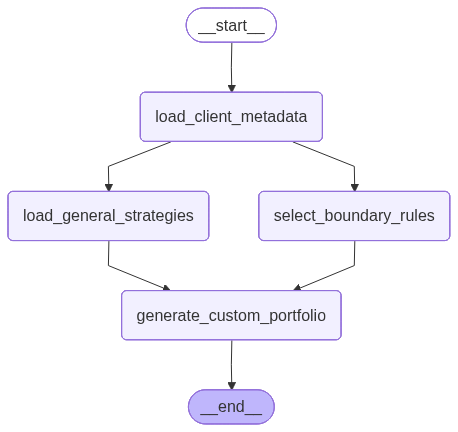

In [5]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [1]:
from azuremodels import llm

ValidationError: 1 validation error for AzureChatOpenAI
__root__
  Invalid `http_client` argument; Expected an instance of `httpx.AsyncClient` but got <class 'httpx.Client'> (type=type_error)